In [86]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [92]:
df_signals = pd.read_csv('../data/01_raw/DNase-seq/HeLa_DNase-seq.bed', sep='\t', usecols=[0, 1, 2], names=['chr', 'start', 'end'])
f = lambda x: x['chr'].split("chr")[-1]
df_signals["chr"] = df_signals.apply(f, axis=1)
df_signals

,chr,start,end
0,1,237723,237873
1,1,714075,714225
2,1,762795,762945
3,1,873735,873885
4,1,901795,901945
...,...,...,...
81149,Y,10020595,10020745
81150,Y,10021177,10021327
81151,Y,10029555,10029705
81152,Y,10037775,10037925


In [93]:
main_df = pd.read_csv('../data/02_intermediate/HiCCUPS_looplist_preprocessed/GSE63525_HeLa_HiCCUPS_looplist.txt')
main_df

,chr,x,y,cell_type,label
0,16,107500.0,147500.0,IMR90,0
1,16,157500.0,417500.0,GM12878,0
2,16,157500.0,232500.0,IMR90,0
3,16,157500.0,232500.0,K562,0
4,16,167500.0,232500.0,GM12878,0
...,...,...,...,...,...
43214,1,246865000.0,246915000.0,HeLa,1
43215,1,247552500.0,247652500.0,GM12878,0
43216,1,247555000.0,247735000.0,GM12878,0
43217,1,248405000.0,248855000.0,GM12878,0


In [94]:
def _count_signals(main_df: pd.DataFrame, signals_df: pd.DataFrame, experiment: str, r: int) -> pd.DataFrame:
    """
    Count the number of experiment signals in both regions of each chromatin loop.
    Args:
        main_df: pandas DataFrame with chromatin loops.
        signals_df: pandas DataFrame with experiment signals.
    Returns:
        pandas DataFrame with chromatin loops and the numbers of experiment signals in both regions of each loop
    """
    main_df[experiment+'_x_signals_count'] = 0
    main_df[experiment+'_y_signals_count'] = 0

    signals_df = signals_df.sort_values(by=['start'])

    # group by chromosome
    main_df_grouped = main_df.groupby('chr')
    signals_df_grouped = signals_df.groupby('chr')

    for main_chr, main_df_chr in tqdm(main_df_grouped):
        for signals_chr, signals_df_chr in signals_df_grouped:
            if main_chr == signals_chr:
                    for idx, row in main_df_chr.iterrows():
                        for region in ['x', 'y']:
                            overlapping_signals = signals_df_chr[(signals_df_chr['start'] >= row[region] - r)&
                                                                (signals_df_chr['start'] <= row[region] + r)&
                                                                (signals_df_chr['end'] >= row[region] - r)&
                                                                (signals_df_chr['end'] <= row[region] + r)]
                            main_df.loc[idx, f'{experiment}_{region}_signals_count'] = len(overlapping_signals)

In [95]:
_count_signals(main_df, df_signals, 'DNase-seq', 50000.0)

100%|██████████| 23/23 [01:05<00:00,  2.84s/it]


In [115]:
main_df['DNase-seq_signals_sum'] = main_df['DNase-seq_x_signals_count'] + main_df['DNase-seq_y_signals_count']

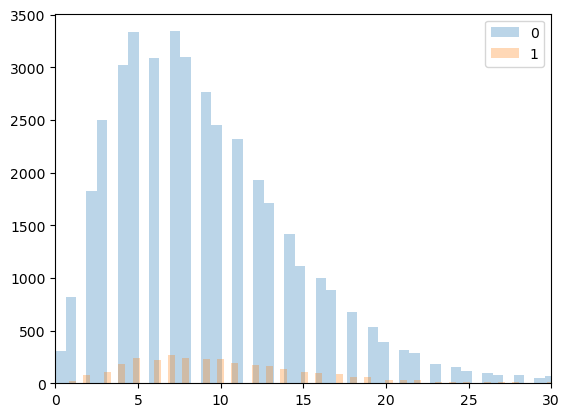

In [116]:
#draw a histogram of the number of DNase-seq signals in the x region of each loop for each label
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=200)
for label in main_df['label'].unique():
    plt.hist(main_df[(main_df['label'] == label)]['DNase-seq_signals_sum'], label=label, **kwargs)
plt.legend()
plt.xlim(0,30)
plt.show()